# Implementing the TIEGCM into ODL
### Part 1: investigation into Alex Forsyth's implementation
### Part 2: new interpolation method (see separate notebook)

In [1]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#######################################################
# PART 1: understanding the text files in Alex's code
#######################################################

def reader(filename):
  '''Function to read out the text files SkimedDensities and SkimedHeights based on Alex's class.
  INPUTS: 'Densities' or 'Heights'
  OUTPUT: array of values'''

  values = []
  Densityfilepath = f'/content/gdrive/MyDrive/msci_satellite_data/odl/Skimed{filename}.txt' # This is adapted from the loadfiles() function in Force_drag_tiegcm.cpp
  with open(Densityfilepath, 'r') as Densityfile:                                           ## Other attempts to read in the data e.g. using np.loadtxt() were unsuccessful
    for line in Densityfile:
        vectorelement = [float(x) for x in line.strip().split(',')]
        values.append(vectorelement)

  return values

SkimedDensities = pd.DataFrame(reader('Densities')) # read in text file and turn into a Pandas data frame to make it easier to handle
SkimedHeights = pd.DataFrame(reader('Heights')) # same as above

print(f'Rows = {SkimedDensities.shape[0]}, Columns = {SkimedDensities.shape[1]}')
print(f'Number of heights and corresponding densities = {SkimedDensities.shape[0]*SkimedDensities.shape[1]}')
print('What does the data frame look like? This is just the first row of SkimedHeights:')
SkimedHeights.head(1)

Rows = 62208, Columns = 72
Number of heights and corresponding densities = 4478976
What does the data frame look like? This is just the first row of SkimedHeights:


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,36184000.0,36237000.0,36283000.0,36323000.0,36357000.0,36387000.0,36414000.0,36440000.0,36467000.0,36494000.0,...,35327000.0,35461000.0,35578000.0,35678000.0,35766000.0,35846000.0,35923000.0,35996000.0,36064000.0,36126000.0


In [5]:
SkimedHeights.max(axis=None)

<ipython-input-5-5a0ae0c7a6c2>:1: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  SkimedHeights.max(axis=None)


0     47330000.0
1     47310000.0
2     47277000.0
3     47258000.0
4     47248000.0
         ...    
67    47193000.0
68    47239000.0
69    47282000.0
70    47320000.0
71    47337000.0
Length: 72, dtype: float64

Alex's thesis (page 25) states that the TIEGCM was in 2.5x2.5 degree resolution, therefore there are:$$$$
Latitude values = 180 / 2.5 = 72$$$$
Longitude values = 360 / 2.5 = 144

In [ ]:
# Given that there are 72 columns, assume this corresponds to 72 lines of latitude
## Rows must therefore correspond to longitude
print(f'Dividing all rows into blocks of 144 (because 72 lat, 144 lon = one TIEGCM grid) = 62208 / 144 = {62208/144}')

Dividing all rows into blocks of 144 (because 72 lat, 144 lon = one TIEGCM grid) = 62208 / 144 = 432.0


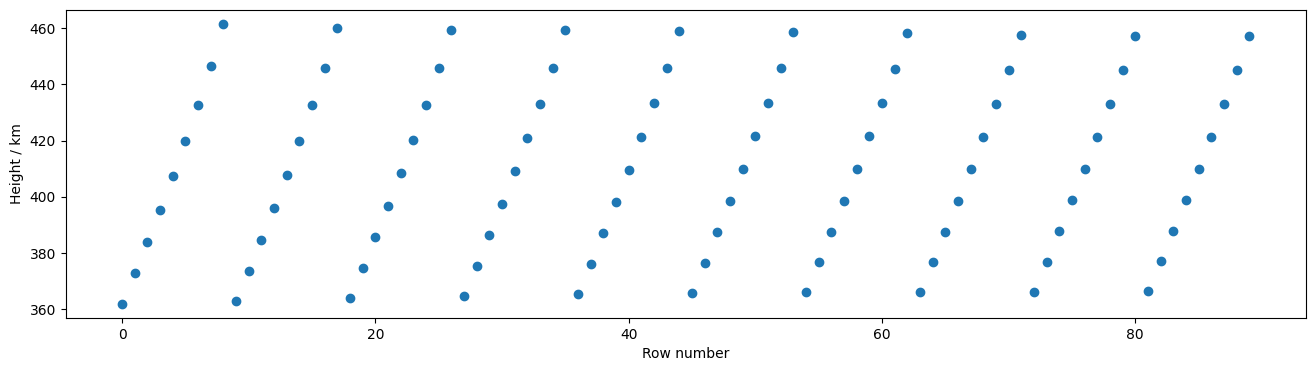

In [ ]:
# Observing the data, it looks like the heights repeat every 9 rows
#SkimedHeights[0].head(20)
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,90,1), SkimedHeights[0].values[0:90]/10**5, 'o')
plt.xlabel('Row number')
plt.ylabel('Height / km')
plt.show()

In [ ]:
### OPTION 1: each group of 9 rows corresponds to the same time
## Alex's thesis (page 25) says the TIEGCM time interval is 15 minutes
print(f'OPTION 1: If each group of 9 rows is a single datetime, number of times in the data = {432/9}')
print(f'OPTION 1: Therefore hours of data: {(432/9)/4}')

### OPTION 2: the 432 lat/lon grids are single times, ie. there are 432 15-min intervals
## Therefore:
print(f'OPTION 2: If there are 432 15-min intervals, then hours of data: {432/4} --> which is {(432/4)/24} days of data')

OPTION 1: If each group of 9 rows is a single datetime, number of times in the data = 48.0
OPTION 1: Therefore hours of data: 12.0
OPTION 2: If there are 432 15-min intervals, then hours of data: 108.0 --> which is 4.5 days of data


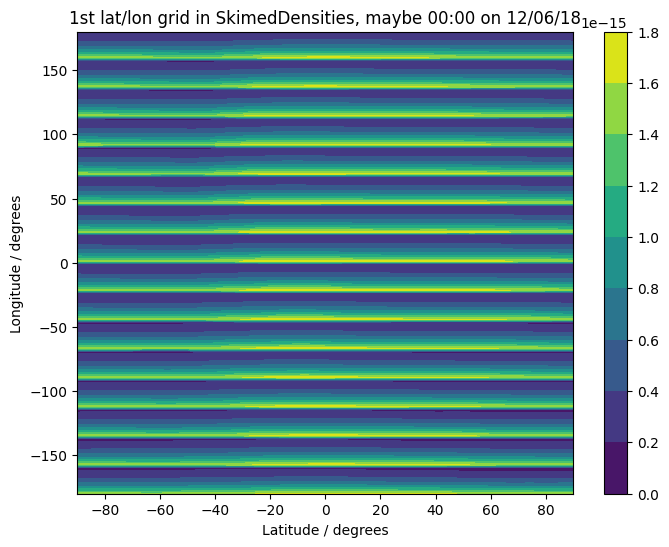

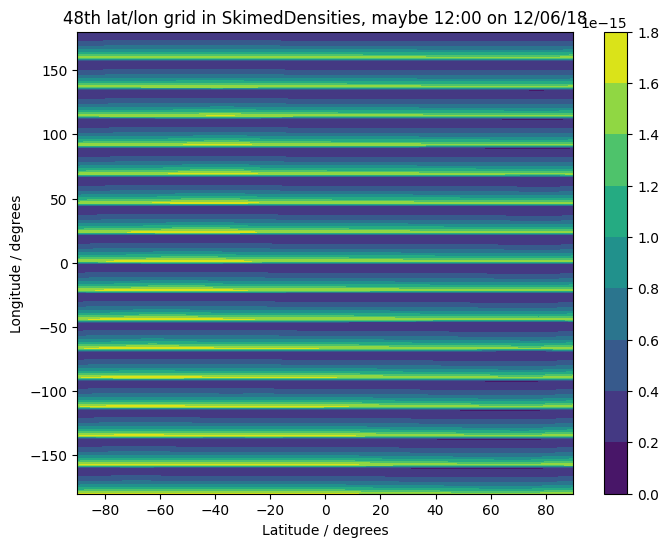

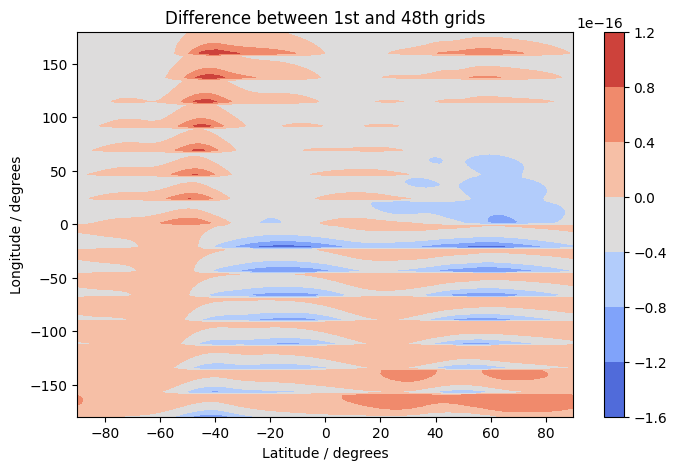

In [ ]:
## VISUALISATION
latitude = np.linspace(-90,90,72)
longitude = np.linspace(-180,180,144)
plt.figure(figsize=(8,6))
plt.contourf(latitude,longitude,SkimedDensities[0:144][0:144])
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('1st lat/lon grid in SkimedDensities, maybe 00:00 on 12/06/18')
plt.colorbar()
plt.show()

## next
plt.figure(figsize=(8,6))
plt.contourf(latitude,longitude,SkimedDensities[6768:6912])
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('48th lat/lon grid in SkimedDensities, maybe 12:00 on 12/06/18')
plt.colorbar()
plt.show()

## difference between the two
plt.figure(figsize=(8,5))
plt.contourf(latitude,longitude,SkimedDensities.values[144:288][0:144]-SkimedDensities.values[0:144][0:144], cmap='coolwarm')
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('Difference between 1st and 48th grids')
plt.colorbar()
plt.show()

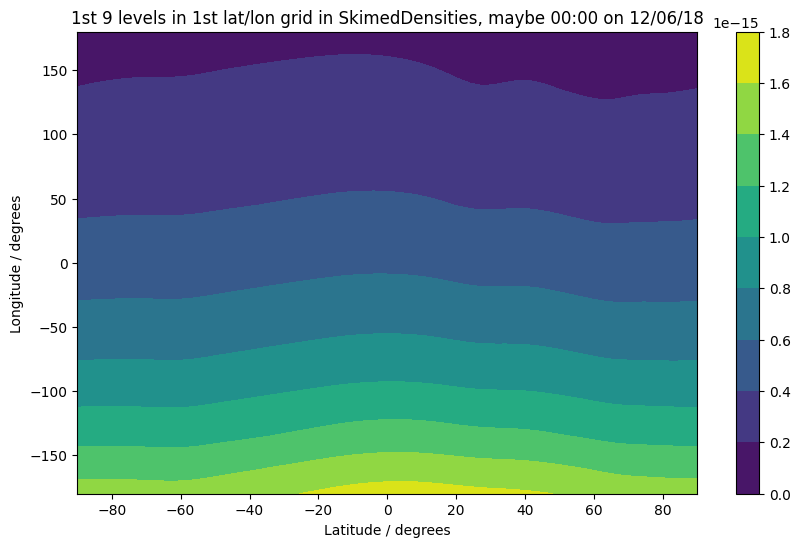

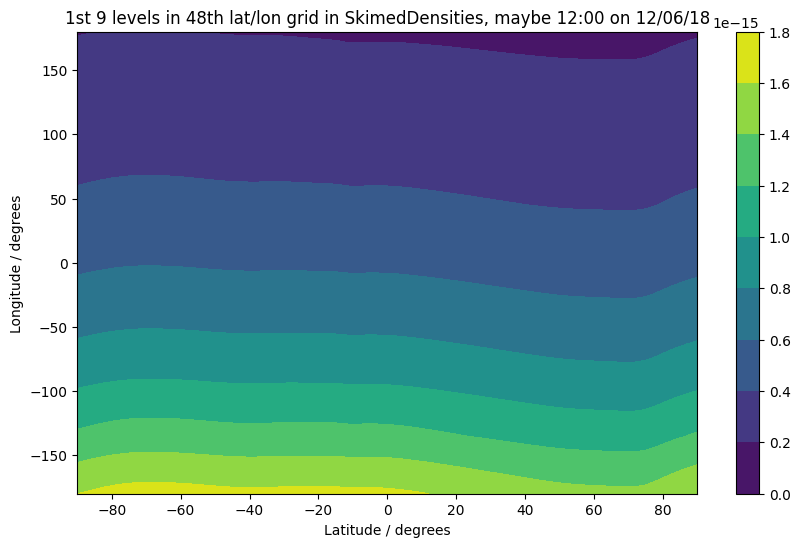

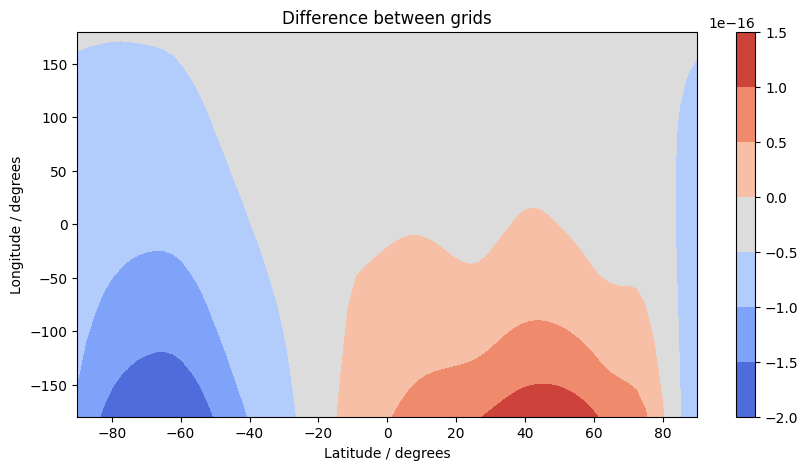

In [ ]:
## VISUALISATION
latitude = np.linspace(-90,90,72)
longitude = np.linspace(-180,180,9)
plt.figure(figsize=(10,6))
plt.contourf(latitude,longitude,SkimedDensities[0:9])
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('1st 9 levels in 1st lat/lon grid in SkimedDensities, maybe 00:00 on 12/06/18')
plt.colorbar()
plt.show()

## next
plt.figure(figsize=(10,6))
plt.contourf(latitude,longitude,SkimedDensities[6768:6777])
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('1st 9 levels in 48th lat/lon grid in SkimedDensities, maybe 12:00 on 12/06/18')
plt.colorbar()
plt.show()

## difference between the two
plt.figure(figsize=(10,5))
plt.contourf(latitude,longitude,SkimedDensities.values[0:9]-SkimedDensities.values[6768:6777], cmap='coolwarm')
plt.xlabel('Latitude / degrees')
plt.ylabel('Longitude / degrees')
plt.title('Difference between grids')
plt.colorbar()
plt.show()

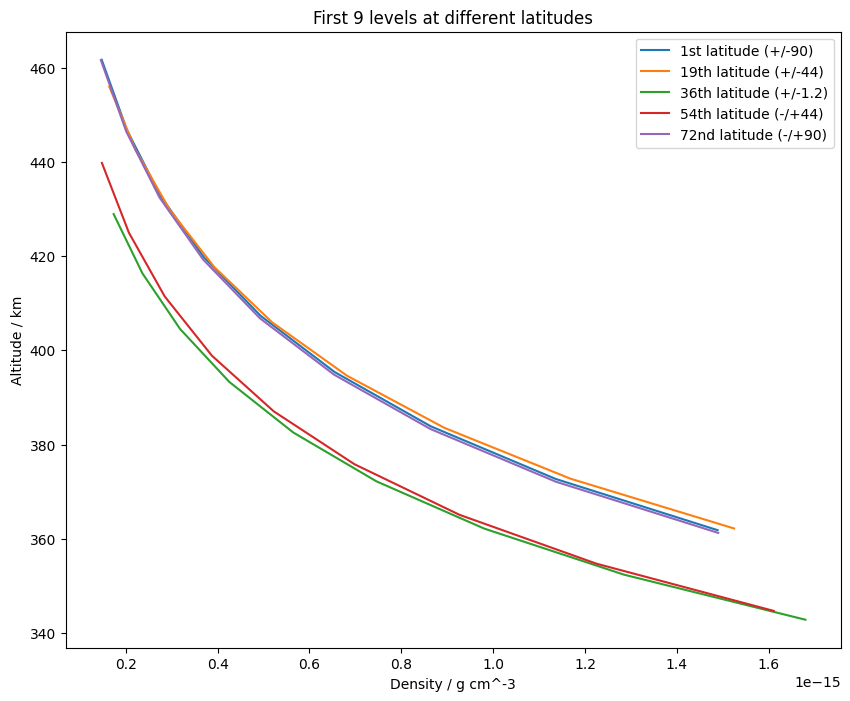

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,36184000.0,36237000.0,36283000.0,36323000.0,36357000.0,36387000.0,36414000.0,36440000.0,36467000.0,36494000.0,...,35327000.0,35461000.0,35578000.0,35678000.0,35766000.0,35846000.0,35923000.0,35996000.0,36064000.0,36126000.0
1,37271000.0,37324000.0,37370000.0,37410000.0,37444000.0,37474000.0,37502000.0,37529000.0,37557000.0,37586000.0,...,36395000.0,36534000.0,36654000.0,36756000.0,36846000.0,36928000.0,37007000.0,37081000.0,37149000.0,37213000.0
2,38387000.0,38439000.0,38484000.0,38524000.0,38557000.0,38587000.0,38615000.0,38643000.0,38672000.0,38703000.0,...,37502000.0,37643000.0,37764000.0,37868000.0,37959000.0,38044000.0,38124000.0,38198000.0,38266000.0,38329000.0
3,39538000.0,39588000.0,39632000.0,39669000.0,39701000.0,39730000.0,39757000.0,39786000.0,39816000.0,39848000.0,...,38655000.0,38796000.0,38917000.0,39021000.0,39114000.0,39200000.0,39281000.0,39354000.0,39421000.0,39482000.0
4,40730000.0,40777000.0,40818000.0,40852000.0,40882000.0,40909000.0,40935000.0,40963000.0,40994000.0,41027000.0,...,39865000.0,40005000.0,40123000.0,40226000.0,40319000.0,40406000.0,40486000.0,40557000.0,40620000.0,40678000.0
5,41975000.0,42016000.0,42051000.0,42081000.0,42107000.0,42131000.0,42155000.0,42181000.0,42213000.0,42247000.0,...,41147000.0,41281000.0,41394000.0,41494000.0,41587000.0,41674000.0,41751000.0,41818000.0,41876000.0,41928000.0
6,43283000.0,43316000.0,43343000.0,43366000.0,43387000.0,43406000.0,43426000.0,43451000.0,43482000.0,43517000.0,...,42521000.0,42645000.0,42748000.0,42843000.0,42934000.0,43018000.0,43092000.0,43152000.0,43202000.0,43245000.0
7,44673000.0,44693000.0,44709000.0,44722000.0,44734000.0,44747000.0,44762000.0,44783000.0,44813000.0,44848000.0,...,44014000.0,44121000.0,44209000.0,44294000.0,44381000.0,44463000.0,44529000.0,44579000.0,44617000.0,44647000.0
8,46166000.0,46169000.0,46169000.0,46168000.0,46169000.0,46171000.0,46178000.0,46195000.0,46223000.0,46257000.0,...,45662000.0,45744000.0,45809000.0,45880000.0,45960000.0,46035000.0,46092000.0,46126000.0,46146000.0,46158000.0


In [ ]:
################################# PLOTTING SINGLE PROFILES
plt.figure(figsize=(10,8))
plt.plot(SkimedDensities[0:9][0], SkimedHeights[0:9][0]/10**5, label='1st latitude (+/-90)')
plt.plot(SkimedDensities[0:9][18], SkimedHeights[0:9][18]/10**5, label='19th latitude (+/-44)')
plt.plot(SkimedDensities[0:9][35], SkimedHeights[0:9][35]/10**5, label='36th latitude (+/-1.2)')
plt.plot(SkimedDensities[0:9][53], SkimedHeights[0:9][53]/10**5, label='54th latitude (-/+44)')
plt.plot(SkimedDensities[0:9][71], SkimedHeights[0:9][71]/10**5, label='72nd latitude (-/+90)')
plt.xlabel('Density / g cm^-3')
plt.ylabel('Altitude / km')
plt.title('First 9 levels at different latitudes')
plt.legend()
plt.show()

SkimedHeights[0:9]

In [ ]:
########################################
########################################
## FRIDAY 23 FEBRUARY 2024
### NEW TEST BASED ON NEW ASSUMPTIONS
########################################
########################################

print(f'With 5x5 resolution and latitudinal range -60-60, there are {SkimedHeights.shape[1]} longitude points, {120/5} latitude points and 9 pressure levels. Therefore every {(24 * 9)} rows corresponds to one grid.')
print(f'This means there are {2592/9} grids in total. If each grid corresponds to one time with 15 min intervals, that means there are {(2592/9)/4} hours of data.')

With 5x5 resolution and latitudinal range -60-60, there are 72 longitude points, 24.0 latitude points and 9 pressure levels. Therefore every 216 rows corresponds to one grid.
This means there are 288.0 grids in total. If each grid corresponds to one time with 15 min intervals, that means there are 72.0 hours of data.


In [ ]:
max(SkimedHeights[5:216].iloc[::9].values.flatten())/10**5

433.79

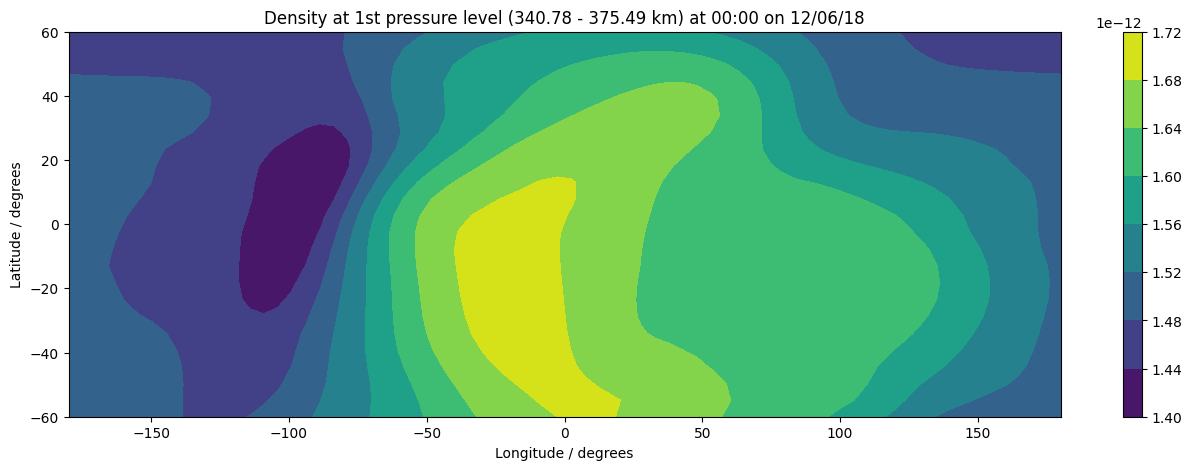

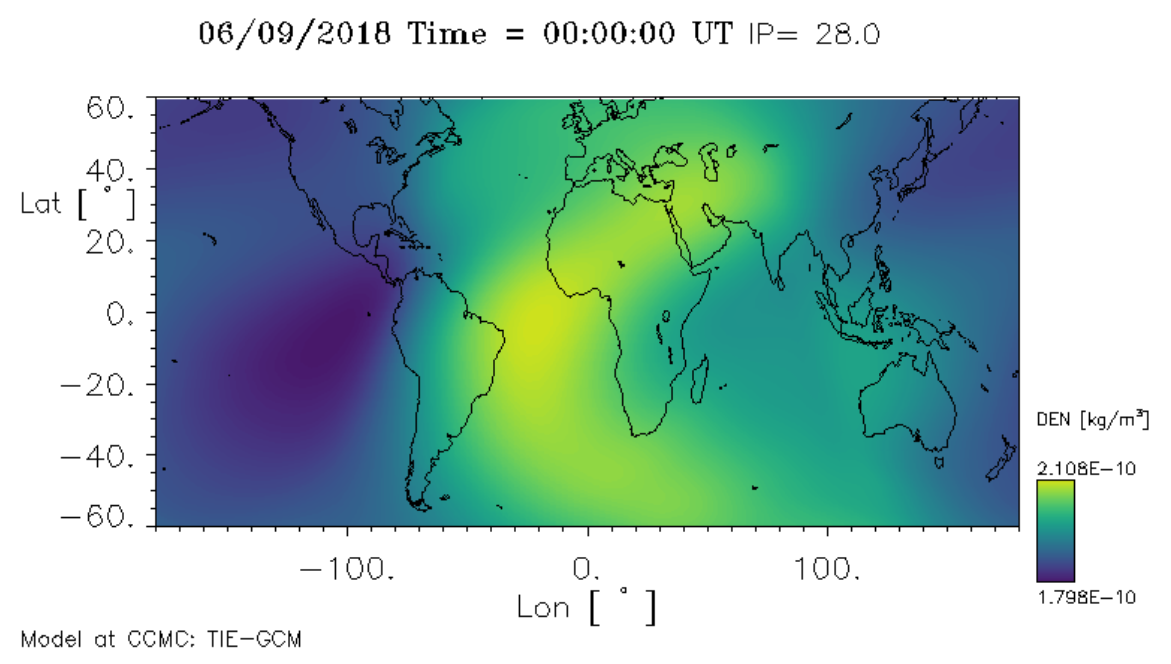

In [ ]:
newlat = np.linspace(-60,60,24)
newlon = np.linspace(-180,180,72)
X,Y = np.meshgrid(newlon, newlat)
plt.figure(figsize=(16,5))
plt.contourf(X, Y, 1000*SkimedDensities[0:216].iloc[::9], cmap='viridis')
plt.xlabel('Longitude / degrees')
plt.ylabel('Latitude / degrees')
plt.title(f'Density at 1st pressure level ({min(SkimedHeights[0:216].iloc[::9].values.flatten())/10**5} - {max(SkimedHeights[0:216].iloc[::9].values.flatten())/10**5} km) at 00:00 on 12/06/18')
plt.colorbar()
plt.show()

# VERIFICATION
Image.open('/content/gdrive/MyDrive/msci_satellite_data/tiegcm_09_06_2018.png')

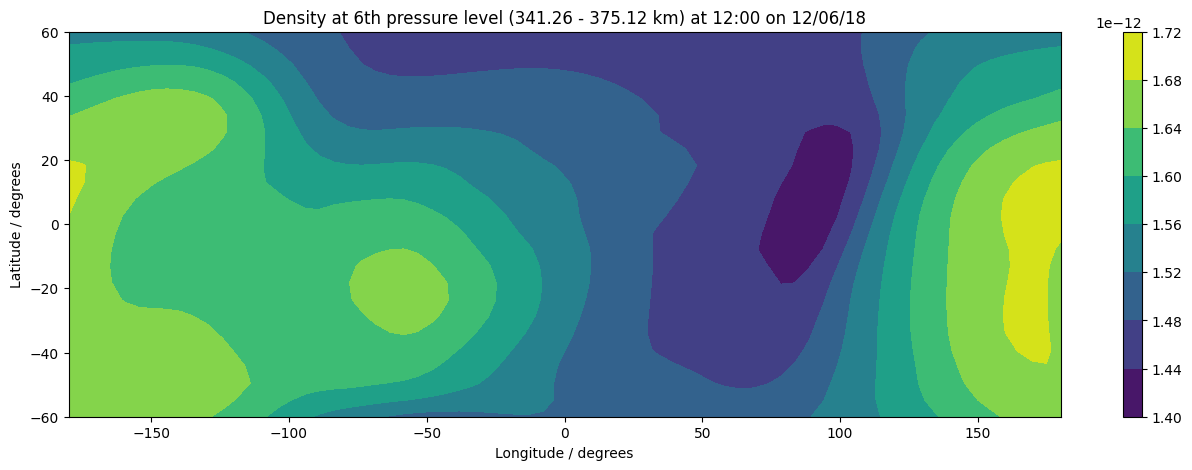

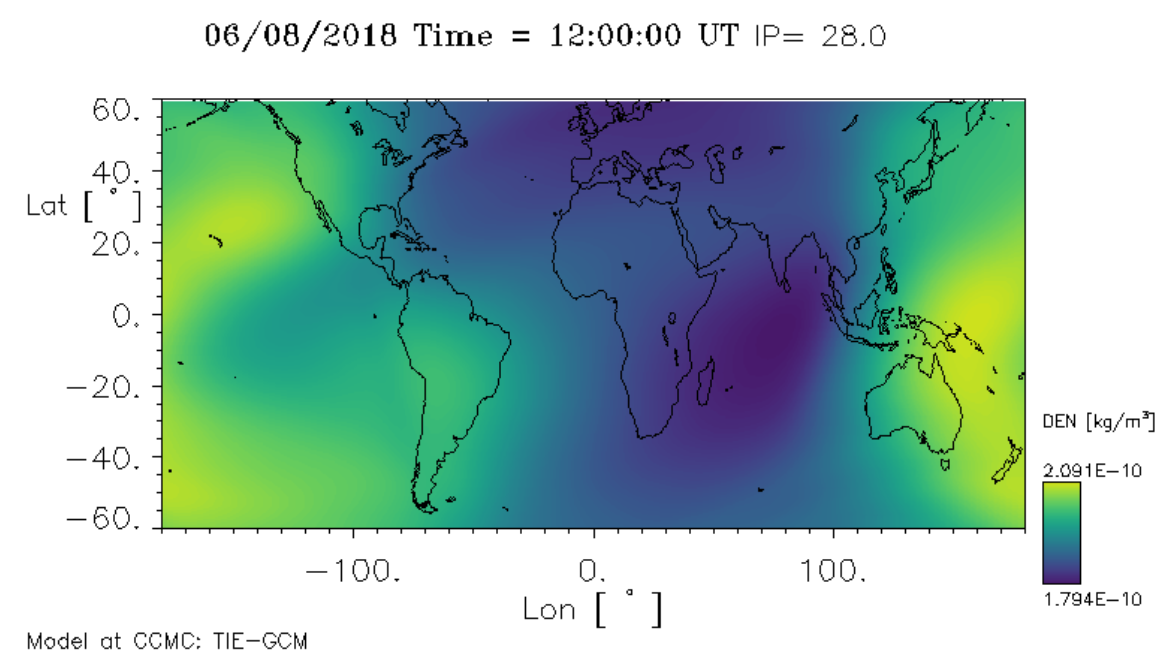

In [ ]:
newlat = np.linspace(-60,60,24)
newlon = np.linspace(-180,180,72)
X,Y = np.meshgrid(newlon, newlat)
plt.figure(figsize=(16,5))
plt.contourf(X, Y, 1000*SkimedDensities[10152:10368].iloc[::9], cmap='viridis')
plt.xlabel('Longitude / degrees')
plt.ylabel('Latitude / degrees')
plt.title(f'Density at 6th pressure level ({min(SkimedHeights[10152:10368].iloc[::9].values.flatten())/10**5} - {max(SkimedHeights[10152:10368].iloc[::9].values.flatten())/10**5} km) at 12:00 on 12/06/18')
plt.colorbar()
plt.show()

# VERIFICATION
Image.open('/content/gdrive/MyDrive/msci_satellite_data/tiegcm_08_06_2018.png')

In [ ]:
def density(day, time, pressure_level):
    values = np.arange(0,62208,216)
    total_minutes = (day - 1) * 24 * 60 + int(time.split(':')[0]) * 60 + int(time.split(':')[1])

    # Calculate the index in the values array
    index = total_minutes // 15

    # Check if the index is within the bounds of the array
    if index < len(values):
        x = values[index]
        print(x)

    newlat = np.linspace(-60,60,24)
    newlon = np.linspace(-180,180,72)
    X,Y = np.meshgrid(newlon, newlat)
    plt.figure(figsize=(18,8))
    plt.contourf(X, Y, SkimedDensities[pressure_level:x].iloc[::9], cmap='jet')
    plt.xlabel('Longitude / degrees')
    plt.ylabel('Latitude / degrees')
    if day == 1:
      plt.title(f'Density at {pressure_level}th pressure level ({min(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} - {max(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} km) at {time} on 12/06/18')
    if day == 2:
      plt.title(f'Density at {pressure_level}th pressure level ({min(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} - {max(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} km) at {time} on 13/06/18')
    if day == 3:
      plt.title(f'Density at {pressure_level}th pressure level ({min(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} - {max(SkimedHeights[pressure_level:x].iloc[::9].values.flatten())/10**5} km) at {time} on 14/06/18')
    plt.colorbar()
    plt.show()

0


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (0, 72)

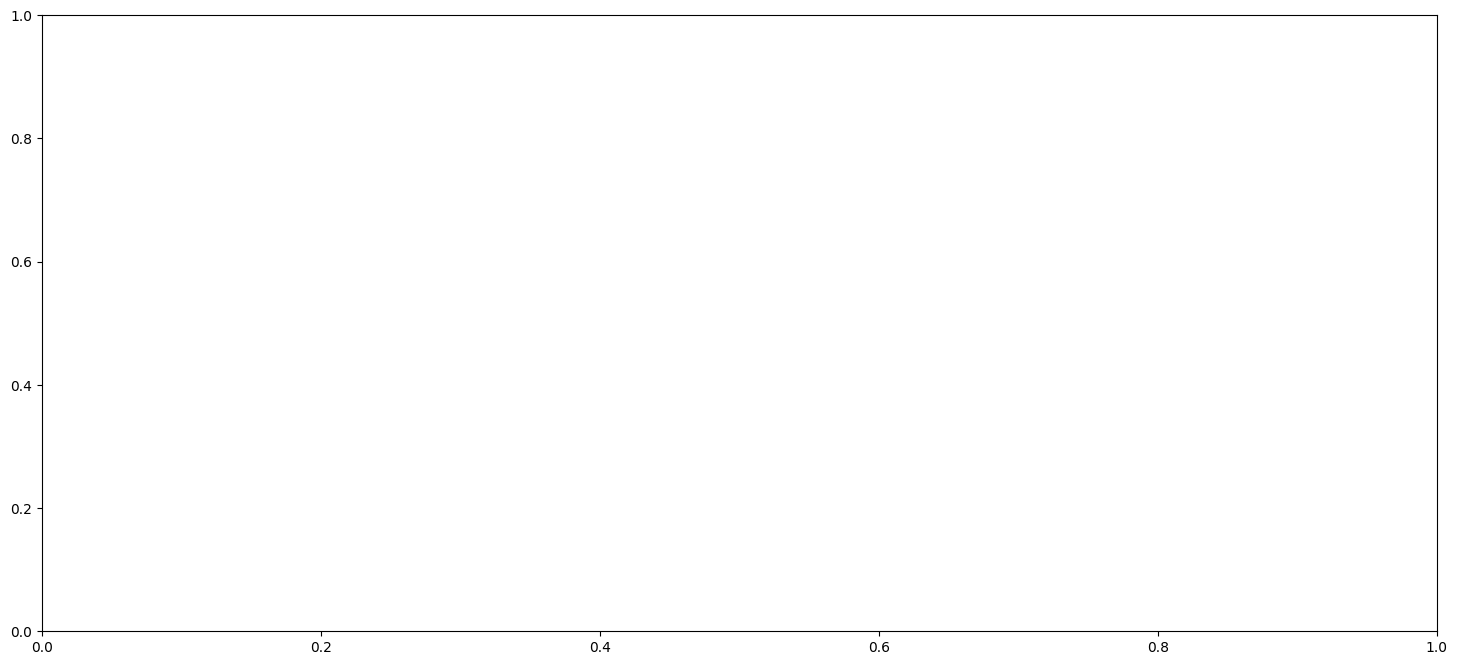

In [ ]:
density(1,'00:00',0)